In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import csv
import os
import sys
sys.path.append("..")
import minimise
import energy_utils as energy
# Enable or disable Tensor Float 32 Execution
tf.config.experimental.enable_tensor_float_32_execution(False)
import scipy.constants as const


            
def LJ_wall_93(z_range, z_wall, epsilon, sigma, cutoff, place='lo'):
    """
    Calculate the Lennard-Jones wall potential for a range of z values.
 
    epsilon is in kT
    sigma is in Angstrom
    cutoff is in Angstrom
    """
 
    hilo = {'lo': 1.0, 'hi': -1.0}
    z_rel = hilo[place]*(z_range - z_wall)
    
    # Avoid division by zero and negative values in z_rel
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio3 = np.where(z_rel > 0, (sigma / z_rel) ** 3, 0)
        ratio9 = ratio3 ** 3
        energy = epsilon * (ratio9 * 2/15 - ratio3)
        
    # Apply boundary conditions
    energy[z_rel <= 0] = np.inf
    energy[z_rel > cutoff] = 0.0
    
    # Shift the potential to ensure it is zero at the cutoff
    cutoff_energy = epsilon * ((sigma / cutoff) ** 9 * 2./15. - (sigma / cutoff) ** 3)
    energy[z_rel <= cutoff] -= cutoff_energy
    
    return energy


In [ ]:
dx = 0.02  # spatial step in Angstroms
kappa_inv = 4.5  # inverse screening length

modelc1_path = "../../models/c1_dipole_Mar9.keras" 
modeln1_path = "../../models/n1_dipole_Mar9.keras"



model_c1 = keras.models.load_model(modelc1_path)
model_n1 = keras.models.load_model(modeln1_path)


temp = 300
L = 80
zbins = np.arange(0, L+0.02, 0.02)
k = 4
kappa_inv = 4.5
dielectric = 1.0
mu_correction = 0.0
V_lo = LJ_wall_93(zbins, L/2-25, 1.0, 1.0, 0.858374218933, 'lo')
V_hi = LJ_wall_93(zbins, L/2+25, 1.0, 1.0, 0.858374218933, 'hi')
Vext = V_lo + V_hi


mu = -8.52
muloc = - Vext + mu
    

/home/btb32/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/models/functional.py:104: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'rho_A' mapping to value <KerasTensor shape=(None, 501), dtype=float32, sparse=False, name=rho> which has name 'rho'. Change the tensor name to 'rho_A' (via `Input(..., name='rho_A')`)
  warnings.warn(
/home/btb32/.conda/envs/tf-gpu/lib/python3.12/site-packages/keras/src/models/functional.py:104: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'elec' mapping to value <KerasTensor shape=(None, 501), dtype=float32, sparse=False, name=phi> which has name 'phi'. Change the tensor name to 'elec' (via `Input(..., name='elec')`)
  warnings.warn(


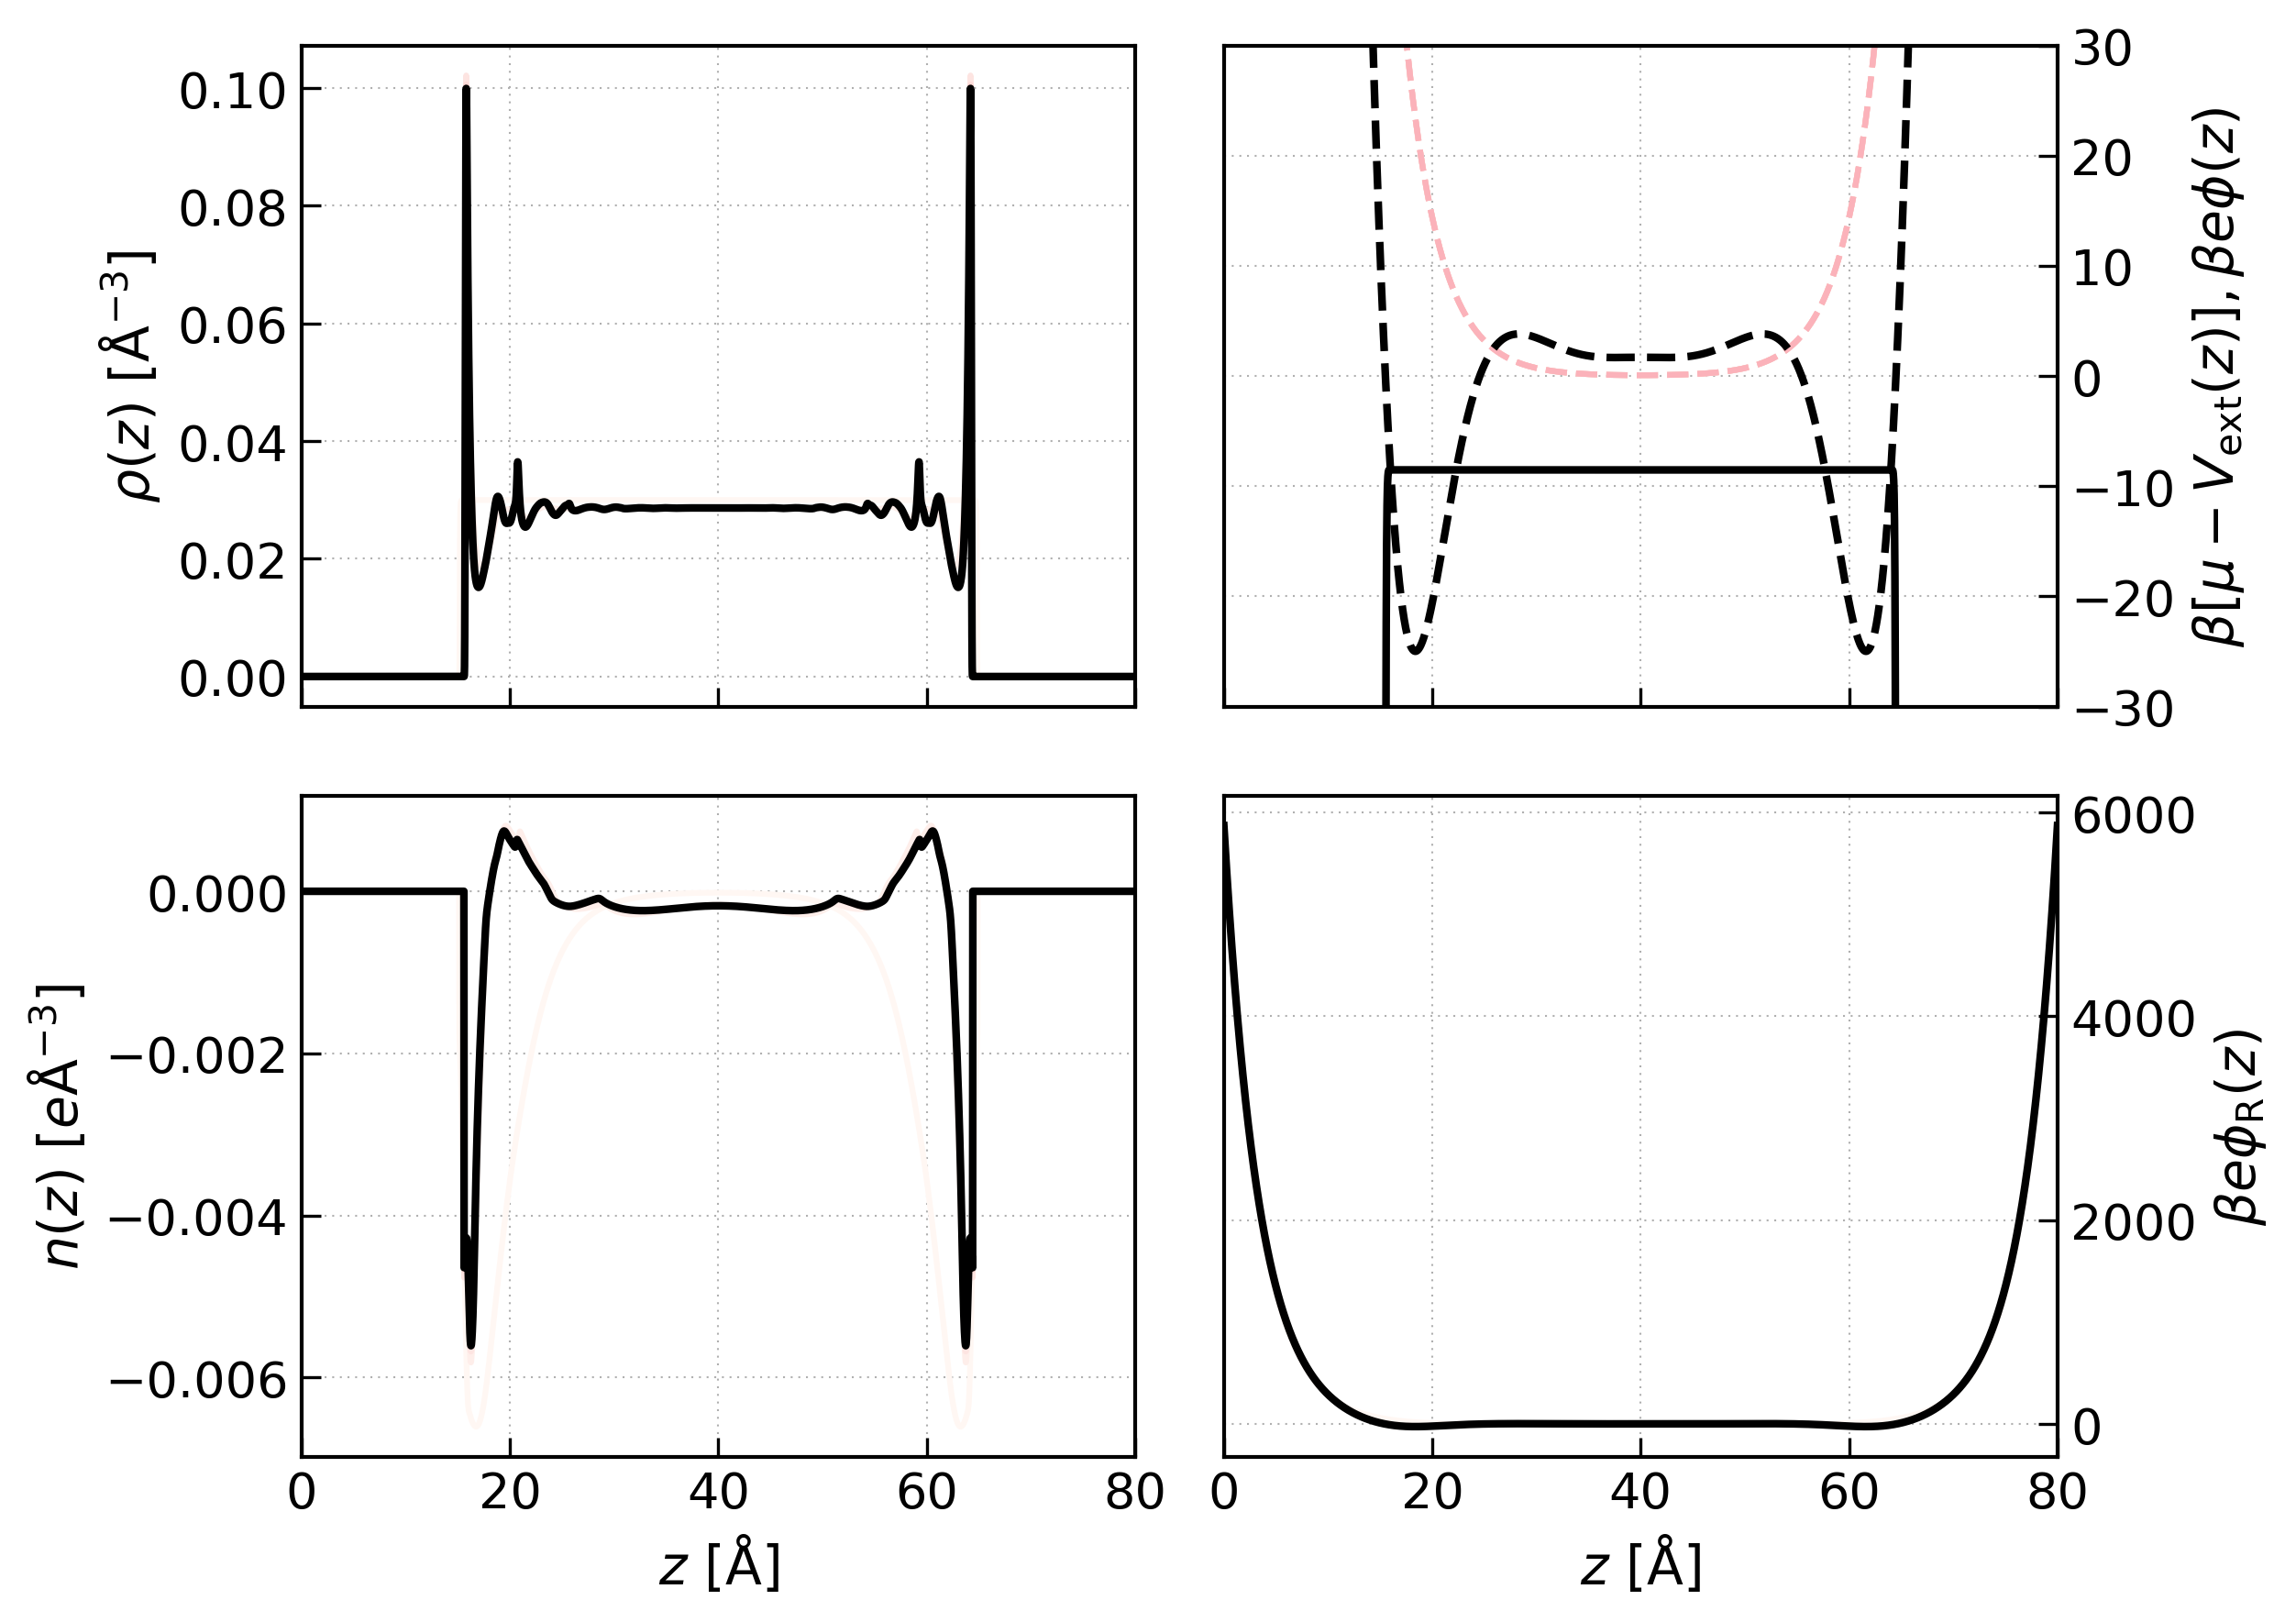

In [6]:

        
intial_guess = np.zeros_like(zbins) + 0.03
A = 0.3
amp_scale = 0.5/np.exp(-A * (L/2-25))    
amplitude = 1.0
E_field = amplitude * amp_scale * (np.exp(-A*zbins) - np.exp(-A*(L-zbins)) )
elec_grad = np.zeros_like(zbins) + E_field / (const.Boltzmann * temp / const.elementary_charge)
Phi_field = (np.exp(-A*zbins) + np.exp(-A*(L-zbins)) ) * amplitude * amp_scale / A
elec = np.zeros_like(zbins) + Phi_field / (const.Boltzmann * temp / const.elementary_charge)

    
if amplitude  == 0.0:
    zero_charge = True
else:
    zero_charge = False

zs, rho_DFT, n_DFT, elecR_DFT = minimise.minimise_LR(
            model_c1, model_n1, zbins, muloc,  elec, temp,
            kappa_inv, dielectric, mu_correction, dx=dx,
            initial_guess=intial_guess, tolerance=1e-6, tolerance_restr = 1e-2,
            maxiter=10000,
            plot=True, plot_every=100, print_every=100,
            symmetric=True, chargesymmetry=True, zero_charge=zero_charge)
    
betaF = energy.get_free_energy(temp, rho_DFT, elec, mu, dx, model_c1, model_n1)

        
#write_profile(output_file, zs, rho_DFT, n_DFT, elec_grad, elecR_grad_DFT, betaF)